In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [2]:
# load local model file and initialize model class
from model import ModelClass
model = ModelClass() # set a few number of periods.


par = model.par
sol = model.sol
sim = model.sim

In [3]:
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve(do_print=True)

We are in t = 69
We are in t = 68
We are in t = 67
We are in t = 66
We are in t = 65
We are in t = 64
We are in t = 63
We are in t = 62
We are in t = 61
We are in t = 60
We are in t = 59
We are in t = 58
We are in t = 57
We are in t = 56
We are in t = 55
We are in t = 54
We are in t = 53
We are in t = 52
We are in t = 51
We are in t = 50
We are in t = 49
We are in t = 48
We are in t = 47
We are in t = 46
We are in t = 45
We are in t = 44
We are in t = 43
We are in t = 42
We are in t = 41
We are in t = 40
We are in t = 39
We are in t = 38
We are in t = 37
We are in t = 36
We are in t = 35
We are in t = 34
We are in t = 33
We are in t = 32
We are in t = 31
We are in t = 30
We are in t = 29
We are in t = 28
We are in t = 27
We are in t = 26
We are in t = 25
We are in t = 24
We are in t = 23
We are in t = 22
We are in t = 21
We are in t = 20
We are in t = 19
We are in t = 18
We are in t = 17
We are in t = 16
We are in t = 15
We are in t = 14
We are in t = 13
We are in t = 12
We are in t = 

In [4]:
# %time model.simulate_prep()
%time model.simulate()

CPU times: total: 391 ms
Wall time: 1.05 s


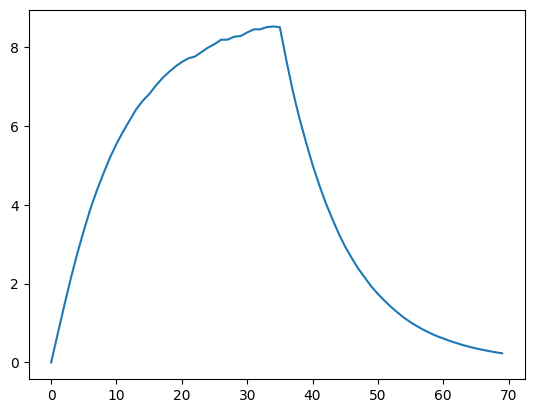

In [5]:
plt.plot(np.arange(par.T),np.mean(model.sim.k[:], axis=0))


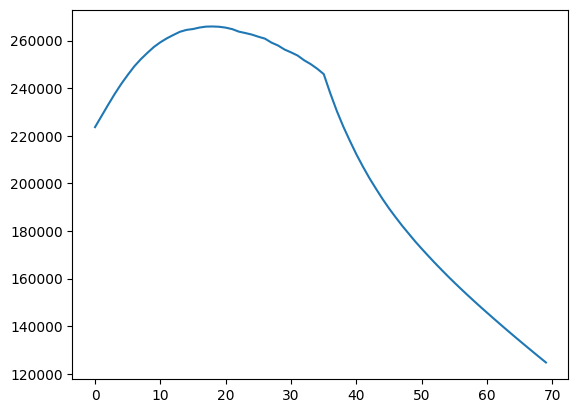

In [6]:
plt.plot(np.arange(par.T),np.mean(model.sim.w[:], axis=0))


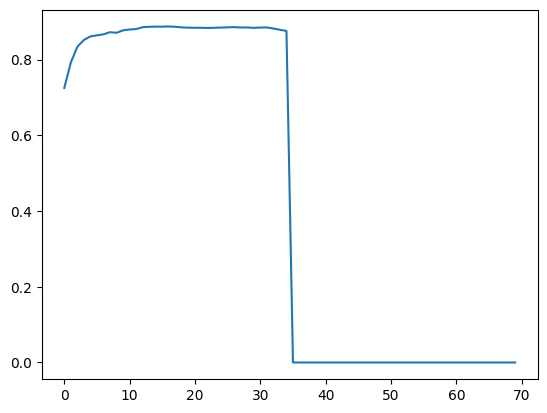

In [7]:
plt.plot(np.arange(par.T),np.mean(model.sim.h[:], axis=0))


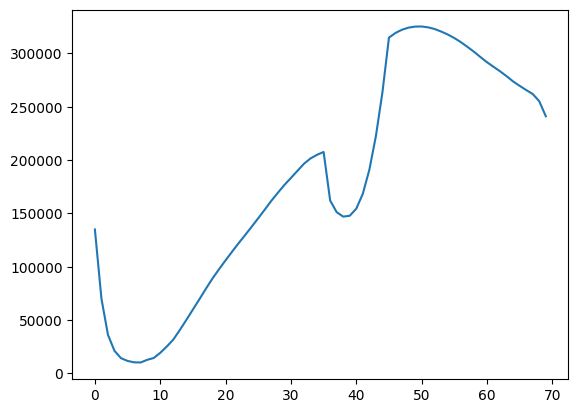

In [20]:
plt.plot(np.arange(par.T),np.mean(model.sim.a[:], axis=0))


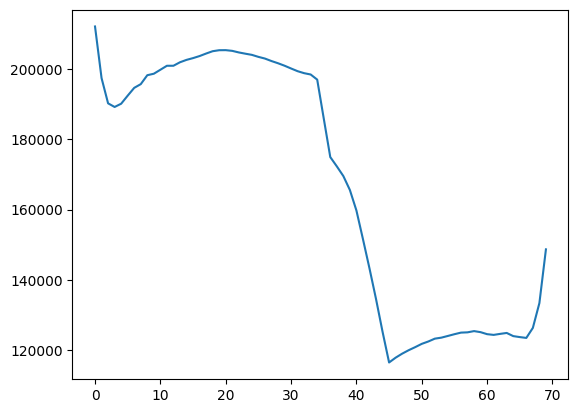

In [21]:
plt.plot(np.arange(par.T),np.mean(model.sim.c[:], axis=0))


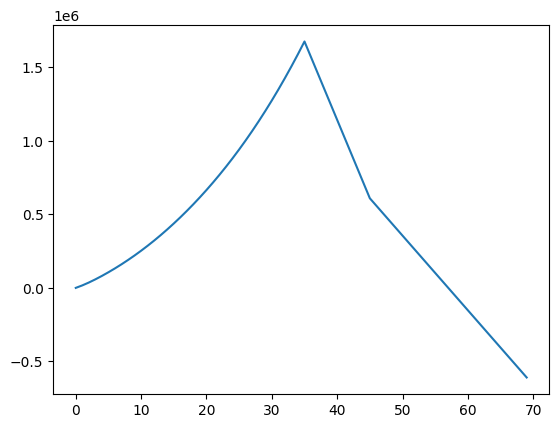

In [22]:
plt.plot(np.arange(par.T),np.mean(model.sim.s[:], axis=0))


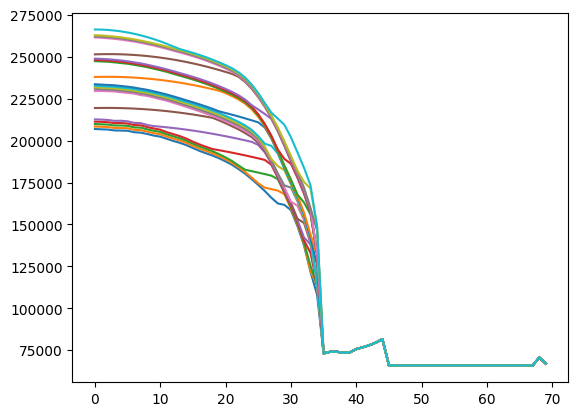

In [12]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 1, 1, i])


In [13]:
sol.V

array([[[[-353.23485789, -353.19086157, -353.14684251, ...,
          -352.28744549, -352.2084642 , -352.12728179],
         [-353.18095011, -353.13699465, -353.09301784, ...,
          -352.23464759, -352.1557411 , -352.07465123],
         [-353.13033719, -353.0864037 , -353.04244956, ...,
          -352.18463756, -352.10577265, -352.02473359],
         ...,
         [-352.40774648, -352.36382539, -352.31988404, ...,
          -351.46239292, -351.38355269, -351.30254323],
         [-352.3596479 , -352.31572681, -352.27178546, ...,
          -351.41429435, -351.33545411, -351.25444466],
         [-352.31154933, -352.26762824, -352.22368689, ...,
          -351.36619578, -351.28735554, -351.20634608]],

        [[-352.84856804, -352.81440489, -352.77862923, ...,
          -351.99565442, -351.9203686 , -351.84223328],
         [-352.79448304, -352.76035914, -352.72462498, ...,
          -351.94272662, -351.86752299, -351.78947176],
         [-352.74377411, -352.70967128, -352.67395942, .

In [14]:
sol.a.shape

(70, 20, 20, 20)

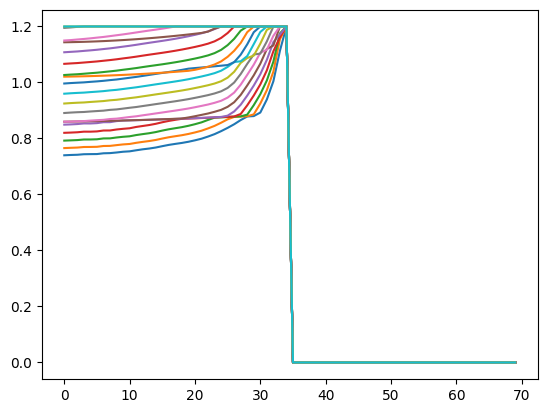

In [15]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.h[:, 1, 1, i])


In [16]:
sol.V[:, 4, 4, :]

array([[-351.64295956, -351.61877141, -351.5940343 , ..., -350.97640143,
        -350.91444845, -350.84911356],
       [-350.76729042, -350.74308195, -350.71831611, ..., -350.09906061,
        -350.03701645, -349.97149697],
       [-349.89358673, -349.8693496 , -349.84453646, ..., -349.22347964,
        -349.16128528, -349.09545495],
       ...,
       [ -78.45755882,  -78.45755882,  -78.45755882, ...,  -78.45755882,
         -78.45755882,  -78.45755882],
       [ -63.68960564,  -63.68960564,  -63.68960564, ...,  -63.68960564,
         -63.68960564,  -63.68960564],
       [ -63.69300723,  -63.69300723,  -63.69300723, ...,  -63.69300723,
         -63.69300723,  -63.69300723]])

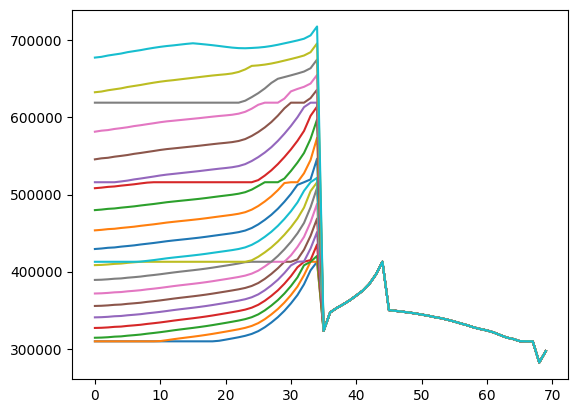

In [17]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.a[:, 4, 4, i])

In [18]:
sol.V[:-1, 4, 4, 4]-sol.V[1:, 4, 4, 4]

array([-8.75806553e-01, -8.73932666e-01, -9.63842642e-01, -1.05350284e+00,
       -1.03913166e+00, -1.19503356e+00, -1.32501993e+00, -1.27398611e+00,
       -1.53111672e+00, -1.51676308e+00, -1.62094356e+00, -1.81592063e+00,
       -1.80161763e+00, -1.92922237e+00, -2.05589328e+00, -2.18721484e+00,
       -2.21484924e+00, -2.29759705e+00, -2.42327829e+00, -2.60620388e+00,
       -2.74575969e+00, -2.88394051e+00, -3.10900584e+00, -3.14580583e+00,
       -3.40488588e+00, -3.36332967e+00, -3.51387223e+00, -3.58584388e+00,
       -3.68433025e+00, -3.97165915e+00, -3.96521619e+00, -4.06205491e+00,
       -4.04305747e+00, -4.22623062e+00, -4.27293258e+00, -4.62338749e+00,
       -4.83112864e+00, -4.77799456e+00, -5.27885859e+00, -5.34591199e+00,
       -5.72832177e+00, -5.72642265e+00, -6.01971810e+00, -5.64051585e+00,
       -5.96853839e+00, -6.68629926e+00, -6.57658162e+00, -6.58952835e+00,
       -6.60942084e+00, -6.96332623e+00, -6.53376810e+00, -6.95451447e+00,
       -6.05425145e+00, -

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\B224264\AppData\Local\Temp\ipykernel_2800\2554536382.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')
C:\Users\B224264\AppData\Local\Temp\ipykernel_2800\2554536382.py:28: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')


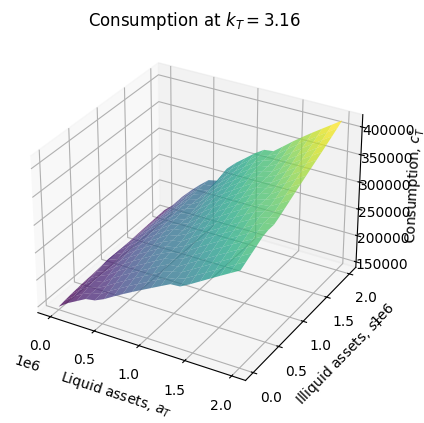

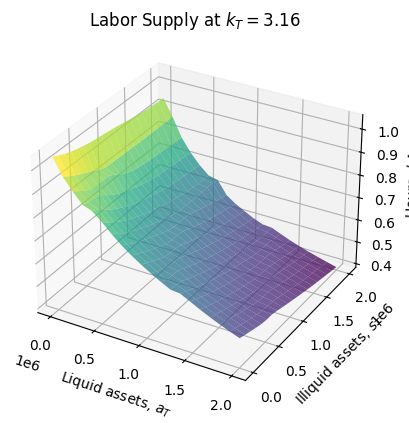

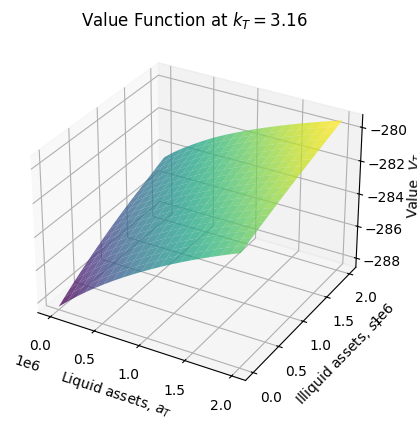

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Choose a fixed k index (e.g., middle of the k_grid)
k_idx = 2
k_fixed = par.k_grid[k_idx]  

# Extract the meshgrid for plotting
a_mesh, s_mesh = np.meshgrid(par.a_grid, par.s_grid, indexing='ij')

# Extract solutions at time t and fixed k
t = 30
c_plot = sol.c[t, :, :, k_idx]  # Fix k_idx
h_plot = sol.h[t, :, :, k_idx]
V_plot = sol.V[t, :, :, k_idx]

# Plot consumption
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, c_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')

# Plot labor supply
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, h_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')

# Plot value function
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, V_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Value, $V_{T}$', title=f'Value Function at $k_T = {k_fixed:.2f}$')

plt.show()
